<a href="https://colab.research.google.com/github/prajyoth8/Waste-Image-Classification/blob/main/Waste_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Waste Image Classification**

In this project, we will be working on **Garbage Dataset which is downloaded from Kaggle.** https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2.  This dataset consists of waste material images i.e. images of 'battery' 'biological' 'cardboard' 'clothes' 'glass' 'metal' 'paper'
 'plastic' 'shoes' 'trash'. **bold text** We will build a convolutional neural network and train it on this images. This is a multi class classification problem and we will use Keras.

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


First we will mount our google drive on colab so that we can use the dataset directly from our drive. For this you first need to upload the data on your drive and then mount the drive on colab.

In [ ]:
# Important imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import cv2
import random
from os import listdir
from sklearn.preprocessing import  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.optimizers import Adam
from PIL import Image
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, LeakyReLU
from sklearn.model_selection import train_test_split

We will start by importing some required libraries.

In [ ]:
# Listing directory
!ls "/content/drive/My Drive/Datasets/Garbage_Data"

battery  biological  cardboard	clothes  glass	metal  paper  plastic  shoes  trash


We will check for folders of class images.

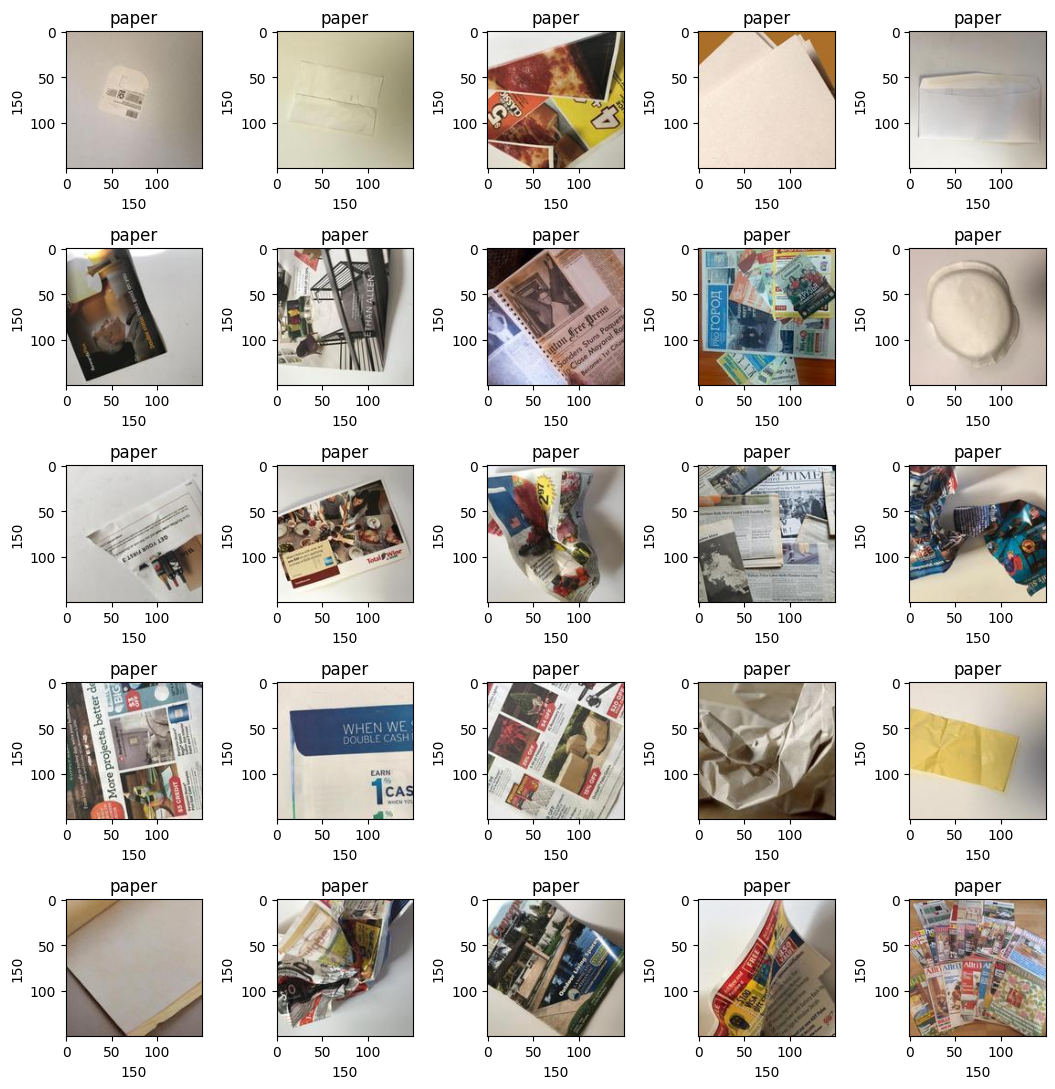

In [ ]:
# Plotting 25 images to check dataset
plt.figure(figsize=(11,11))
path = "/content/drive/My Drive/Datasets/Garbage_Data/paper"
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(listdir(path))))
    plt.imshow(rand_img)
    plt.title('paper')
    plt.xlabel(rand_img.shape[1], fontsize = 10)
    plt.ylabel(rand_img.shape[0], fontsize = 10)

Let's visualize some of the images that we will be working on. Also we will observe x and y dimensions of the image.

In [ ]:
# Setting root directory path and creating empty list
dir = "/content/drive/My Drive/Datasets/Garbage_Data"
root_dir = listdir(dir)
image_list, label_list = [], []

Setting the root directory for the dataset and storing all the folders name of the dataset. We will also create 2 empty list for image and lables.

In [ ]:
# Reading and converting image to numpy array
def standardize_image(img):
    if img.mode == 'L' or img.mode == 'I':  # Grayscale or integer pixel representations
        img = img.convert('RGB')
    elif img.mode == 'RGBA':  # RGBA to RGB
        # Create a new image with a white background
        background = Image.new('RGB', img.size, (255, 255, 255))
        # Paste the RGBA image onto the background (RGB) using the alpha channel as a mask
        background.paste(img, mask=img.split()[3])
        img = background
    elif img.mode != 'RGB':
        # For any other mode, convert directly to RGB
        img = img.convert('RGB')
    return img


for directory in root_dir:
    for files in listdir(f"{dir}/{directory}"):
        image_path = f"{dir}/{directory}/{files}"
        image = Image.open(image_path)
        image = standardize_image(image)  # Standardize the image
        # image = image.resize((150,150))  # Resize image
        image = img_to_array(image)
        image_list.append(image)
        label_list.append(directory)


Next we need to resize images as some of the images don't have same dimensions. So, we will read and resize all the images to (150, 150). Then we will convert it into array and appending the list created above with the image and its label.

In [ ]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts

clothes       5325
glass         4096
paper         2726
plastic       2540
cardboard     2345
shoes         1977
metal         1869
biological     988
battery        939
trash          810
dtype: int64

Checking for images per class.

In [ ]:
# Checking count of classes
num_classes = len(label_counts)
num_classes

10

Storing the number of classes which will be used further in model architecture.

In [ ]:
# for idx, img in enumerate(image_list):
#     img = np.array(img)
#     if img.shape != (150, 150, 3):
#         print(f"Image at index {idx} has shape {img.shape}")


In [ ]:
# Checking x data shape
np.array(image_list).shape

(23615, 150, 150, 3)

Check the shape of the x data for input layer of model architecture.

In [ ]:
# Checking y data shape
label_list = np.array(label_list)
label_list.shape

(23615,)

Checking the number of labels in y data which should be equal to total number of images.

In [ ]:
# Splitting dataset into test and train
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10)

Now we will **split our dataset into testing and training using train_test_split() from sklearn.**

In [ ]:
# Normalize and reshape data
x_train = np.array(x_train, dtype=np.float16) / 255.0
x_test = np.array(x_test, dtype=np.float16) / 255.0
x_train = x_train.reshape( -1, 150,150,3)
x_test = x_test.reshape( -1, 150,150,3)

Next we will **normalize the images by dividing them with 255 and we will also reshape x_train and x_test data.**

In [ ]:
# Binarizing labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
print(lb.classes_)

['battery' 'biological' 'cardboard' 'clothes' 'glass' 'metal' 'paper'
 'plastic' 'shoes' 'trash']


Here we will use **label binarizer to one hot encode our y data**. We will also print the sequence of the classes.

In [ ]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

Now we will **split the training data to validation and training data**.

In [ ]:
# Data Augmentation
augmented_data_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


Here we perform **Data Augumentation** to artificially expand the training dataset.

In [ ]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

An **Early Stopping** callback is set up to prevent overfitting.

In [ ]:
# Class Weights Calculation
from sklearn.utils.class_weight import compute_class_weight

y_train_classes = np.argmax(y_train, axis=1)

# Calculate the class weights, which will be used to give more importance to underrepresented classes during training
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_classes), y=y_train_classes)

# Map the class weights to the corresponding class indices
class_weights_dict = {i : class_weights[i] for i, label in enumerate(np.unique(y_train_classes))}


**Class weights** are computed to give more importance to underrepresented classes during training.

In [ ]:
# Model Architecture

# Loading a pre-trained model

from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

# Load the VGG16 pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add new layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)


58889256/58889256 [==============================] - 3s 0us/step


**Integrating a Pre-Trained Model (VGG16)**
For this project, we enhance our convolutional neural network's capability by leveraging a pre-trained model. The pre-trained model of choice is VGG16, which has been trained on the ImageNet dataset. ImageNet is a large visual database designed for use in visual object recognition software research.

VGG16 is instantiated with pre-loaded ImageNet weights, include_top is set to False to exclude the top (or the last fully connected layers), and input_shape is set to the dimensions expected by our model.

This code freezes all layers of the base_model except for the last four. This technique, known as transfer learning, allows us to re-use the learned features from the ImageNet dataset without altering them during our training process, which saves computational resources and utilizes the high-quality features learned from a massive dataset.

The output of the base_model is passed through a GlobalAveragePooling2D layer to reduce the spatial dimensions. A Dense layer with 1024 units and ReLU activation is then added for learning the more complex combinations of the lower-level features.

Finally, another Dense layer with a number of neurons equal to the number of classes in the dataset (num_classes) uses the softmax activation function. This layer outputs a probability distribution over the classes, allowing us to make a prediction.



In [ ]:
# Compiling model
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0005),metrics=['accuracy'])

For compiling the model we need to pass 3 parameters namely loss, optimizer and metrics. Here we will use loss as categorical_crossentropy, optimizer as Adam and metrics as accuracy.

In [ ]:
# Training the model
history = model.fit(
    augmented_data_gen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=100,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

Epoch 1/100
473/473 [==============================] - 85s 162ms/step - loss: 1.1241 - accuracy: 0.6030 - val_loss: 0.6411 - val_accuracy: 0.7830
Epoch 2/100
473/473 [==============================] - 75s 159ms/step - loss: 0.7003 - accuracy: 0.7601 - val_loss: 0.5870 - val_accuracy: 0.8029
Epoch 3/100
473/473 [==============================] - 75s 158ms/step - loss: 0.5736 - accuracy: 0.8071 - val_loss: 0.4874 - val_accuracy: 0.8391
Epoch 4/100
473/473 [==============================] - 75s 158ms/step - loss: 0.4743 - accuracy: 0.8362 - val_loss: 0.4369 - val_accuracy: 0.8637
Epoch 5/100
473/473 [==============================] - 76s 160ms/step - loss: 0.4241 - accuracy: 0.8565 - val_loss: 0.3987 - val_accuracy: 0.8788
Epoch 6/100
473/473 [==============================] - 76s 160ms/step - loss: 0.3653 - accuracy: 0.8741 - val_loss: 0.4107 - val_accuracy: 0.8748
Epoch 7/100
473/473 [==============================] - 75s 159ms/step - loss: 0.3209 - accuracy: 0.8863 - val_loss: 0.3847 -

Fitting the model with the data and finding out the accuracy at each epoch to see how our model is learning. Now we will train our model on **100 epochs and a batch size of 32.**

In [ ]:
# Saving model
model.save("/content/drive/My Drive/Waste_Seg_Model1")

We will save the model using model.save() to use it later for prediction.

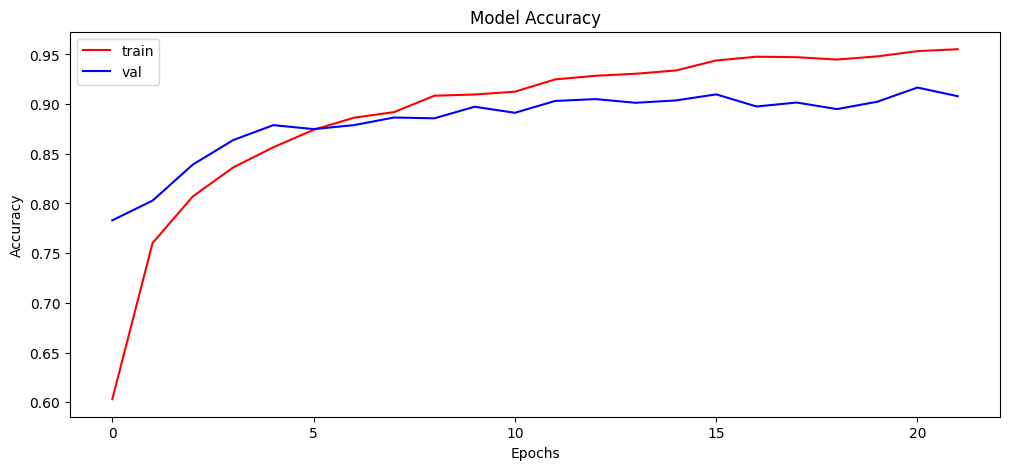

In [ ]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

Plotting the accuracy of the model for the training history.

**Training Accuracy (Red Line):** It increases sharply at the start, indicating rapid learning in the initial epochs. It continues to improve more gradually as training progresses, leveling off around 95% accuracy, which suggests that the model is fitting the training data well.

**Validation Accuracy (Blue Line):** It also rises sharply, but it starts leveling off sooner than the training accuracy. The validation accuracy indicates how well the model generalizes to new, unseen data. The highest point is close to 90%, which is quite good.

**Gap Between Training and Validation Accuracy:** The gap between the training and validation accuracy starts small but grows slightly over time. This could be a sign of the model beginning to overfit the training data. However, the gap remains relatively small, which is a positive indicator of the model’s generalization.

**General Trend:** Both accuracies seem to plateau towards the end of training, which is typical as the model converges to a solution.

From this graph, we can deduce that the model has learned well from the training data and is also performing well on the validation set. The accuracy on the validation set is an essential measure as it is reflective of how the model will perform on real-world data it has not seen before.

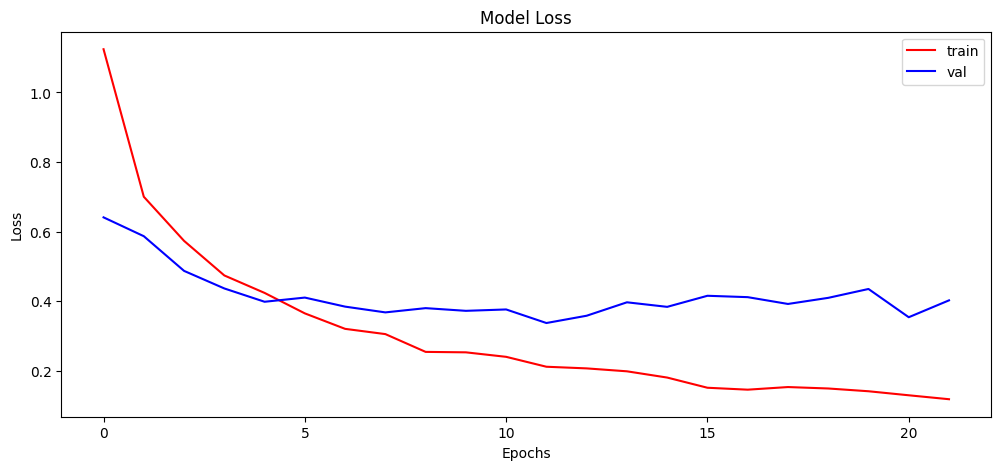

In [ ]:
#Plot the loss history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

Plotting the loss of the model for the training history.

**Training Loss (Red Line):** This line represents the model's loss on the training dataset. Ideally, it should decrease steadily over time as the model learns from the training data. A smooth and consistent downward trend indicates that the model is learning effectively.

**Validation Loss (Blue Line):** This line shows the model's loss on the validation dataset. Like the training loss, it should also decrease over time, but it may have some fluctuations due to the model encountering data it hasn't learned from yet. A validation loss that decreases in tandem with the training loss suggests that the model is generalizing well and not overfitting.

**Gap Between Training and Validation Loss:** A small gap between the training and validation loss lines is typically a good sign. It means that the model isn't just memorizing the training data and is able to perform well on unseen data. However, if the validation loss begins to increase while the training loss continues to decrease, it might be an indicator of overfitting.

**Convergence:** If both losses plateau, it means the model might not benefit from further training on the current data with the current settings. It has possibly reached its performance capacity given the complexity of the model and the data.

It seems that the model's loss on both training and validation datasets decreases over epochs, suggesting that the model is learning as expected.


In [ ]:
# Calculating test accuracy
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

148/148 [==============================] - 12s 84ms/step - loss: 0.3419 - accuracy: 0.9145
Test Accuracy: 91.44611358642578


Evaluating the model to know the accuracy of the model on the test data.

In [ ]:
# Storing model predictions
y_pred = model.predict(x_test)

148/148 [==============================] - 10s 65ms/step


Generating predictions for test data and storing them into y_pred.

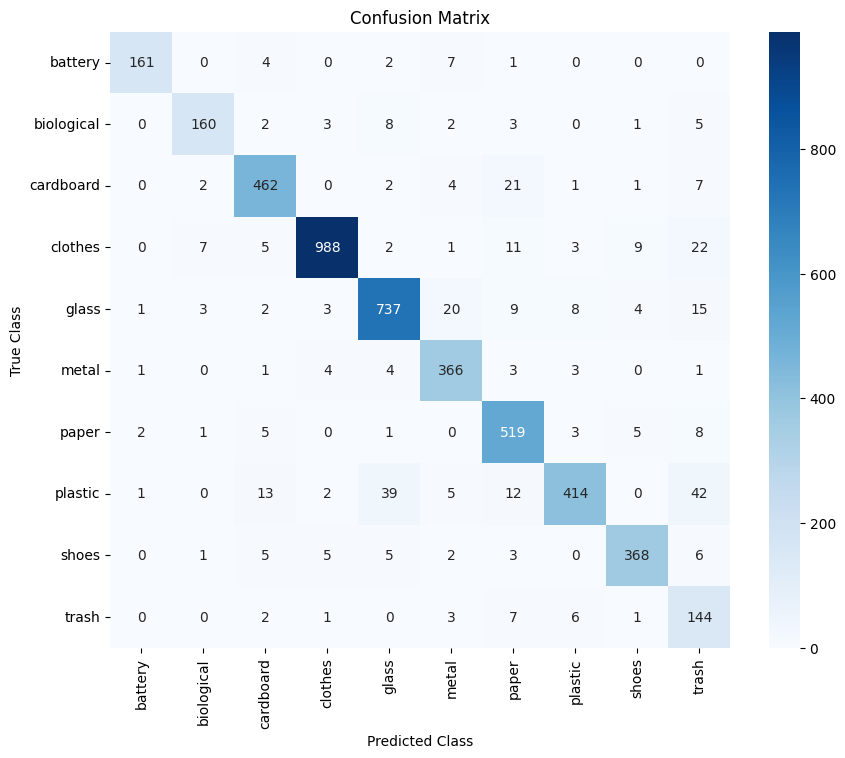

In [ ]:
# Confusion matrix analysis
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert one-hot encoded test labels to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

The confusion matrix shows the classification results of the model. **Each row of the matrix represents the instances of the actual class (True class), and each column represents the instances as predicted by the model (Predicted class). The diagonal elements show the number of correct predictions for each class, and the off-diagonals represent misclassifications.**

Here's a general interpretation:

**High Diagonal Values:** The cells with higher values along the diagonal, such as 'battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', and 'shoes', indicate a high number of correct predictions for these classes.

**Misclassifications:** Off-diagonal cells with higher values indicate confusion between classes. For example, 'plastic' seems to have a significant number of instances confused with 'glass' and 'paper'. Similarly, 'clothes' have some confusion with 'biological', 'glass', and 'trash'.

**Least Confused:** Some classes like 'battery' and 'biological' have low off-diagonal values, indicating they are less confused with other classes.

**Overall Accuracy:** Given the high diagonal values for most classes, it appears that the model is quite accurate across the board.

**Areas for Improvement:** Classes with higher misclassifications might benefit from more training data, data augmentation, or perhaps a review of how these images differ from other classes to improve feature extraction.

**Class Imbalance:** If certain classes have a significantly lower number of samples, this could lead to fewer instances of correct classifications.

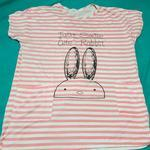

In [ ]:
# Plotting image to compare
img = array_to_img(x_test[0])
img

Visualizing an image to be predicted in further steps.

In [ ]:
# Finding max value from predition list and comaparing original value vs predicted
labels = lb.classes_
print(labels)
print("Originally : ",labels[np.argmax(y_test[0])])
print("Predicted : ",labels[np.argmax(y_pred[0])])

['battery' 'biological' 'cardboard' 'clothes' 'glass' 'metal' 'paper'
 'plastic' 'shoes' 'trash']
Originally :  clothes
Predicted :  clothes


Now, we will create list of labels using object of label binarizer. We will print that list and finally we will print out the prediction and the original label of the image we visualized above using argmax().

In [ ]:
# Prediction on a New Image

from keras.preprocessing.image import load_img, img_to_array

new_image = load_img('/content/drive/My Drive/test_images/metal.jpg', target_size=(150, 150))


I took a sample image which is also stored in Google Drive in the path /content/drive/My Drive/test_images/metal.jpg. In the above code the image is resized to (150, 150).

In [ ]:
new_image = img_to_array(new_image)
new_image = np.expand_dims(new_image, axis=0)  # Model expects a batch dimension

# Applying normalization as done for the training data
new_image = new_image / 255.0


In [ ]:
prediction = model.predict(new_image)

# Get the predicted class index
predicted_class_index = np.argmax(prediction, axis=1)
predicted_class_name = labels[predicted_class_index][0]  # Retrieve the class name corresponding to the index

# Output the prediction
print(f"Predicted class: {predicted_class_name}")


1/1 [==============================] - 0s 22ms/step
Predicted class: metal


Prediction of the model to the image which is not in the dataset.

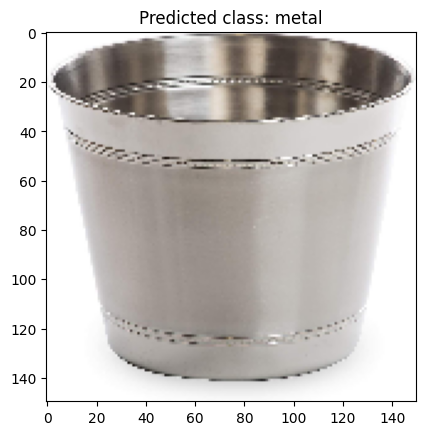

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(new_image.squeeze())  # Squeeze is used to reduce the batch dimension for display purposes
plt.title(f"Predicted class: {predicted_class_name}")
plt.show()


Visulalizing the Predicted Image.

# **Conclusion:**

The Waste Image Classification project successfully **developed a convolutional neural network model using Keras** and trained it on a dataset containing various categories of waste items. **The model's architecture was notably enhanced by integrating a pre-trained VGG16 network, leveraging transfer learning to improve feature extraction capabilities.**

The project's thorough approach included **preprocessing steps such as image resizing and normalization, one-hot encoding of labels, and splitting the dataset into training, validation, and test sets. Data augmentation and class weight adjustments were strategically implemented to tackle class imbalance and enhance the model's ability to learn from underrepresented categories.**

The final model demonstrated robust performance, achieving high accuracy on both validation and unseen test data, as evidenced by the accuracy and loss metrics over training epochs. **The confusion matrix analysis revealed a high rate of correct classifications across most classes, with some confusion present between certain categories like 'plastic' and 'glass'.**|

# **Scope:**

The current model's high accuracy paves the way for real-world applications in waste management systems. Its ability to classify waste into specific categories can be utilized in automated waste sorting facilities, reducing manual sorting needs and improving recycling processes.

Further, the model can be deployed as part of a mobile or web application to educate and assist individuals in segregating waste correctly, thus promoting environmentally friendly waste disposal practices.